# Simple Cycle Scoring Example with BMS and Random Sampling
The aim of this example notebook is to use the AutoRA `Cycle` to recover a ground truth theory from some noisy data using BSM and random sampling. We will evaluate the model with AutoRa's scoring and plotting functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import logging

from autora.cycle import Cycle, cycle_specified_score, plot_cycle_score, plot_results_panel_2d
from sklearn.metrics import r2_score
from autora.experimentalist.sampler import random_sampler, nearest_values_sampler
from autora.experimentalist.pipeline import make_pipeline
from autora.variable import VariableCollection, Variable
from autora.skl.bms import BMSRegressor

## Ground Truth and Problem Space
The ground truth we are trying to recover will be an oscillating function with a parabolic component.
The space of allowed x values is reals between -10 and 10 inclusive. We discretize them as we don't currently have a sampler which can sample from the uniform distribution.

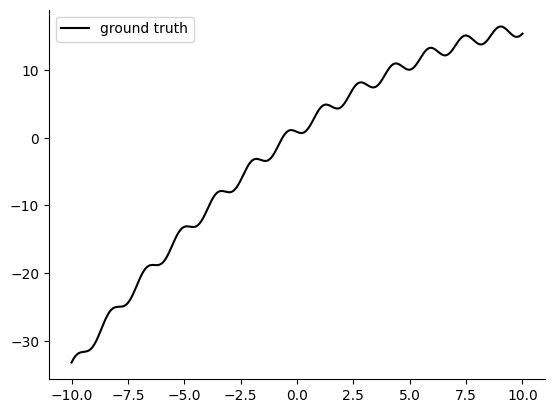

In [2]:
def ground_truth(xs):
    oscillating_component = np.sin((4. * xs) - 3.)
    parabolic_component =  (-0.1 * xs ** 2.) + (2.5 * xs) + 1.
    ys = oscillating_component + parabolic_component
    return ys

study_metadata = VariableCollection(
   independent_variables=[Variable(name="x1", allowed_values=np.linspace(-10, 10, 500))],
   dependent_variables=[Variable(name="y")],
   )

plt.plot(study_metadata.independent_variables[0].allowed_values, ground_truth(study_metadata.independent_variables[0].allowed_values), c="black", label="ground truth")
plt.legend()

## Experiment Runner
We create a synthetic experiment that adds noise.

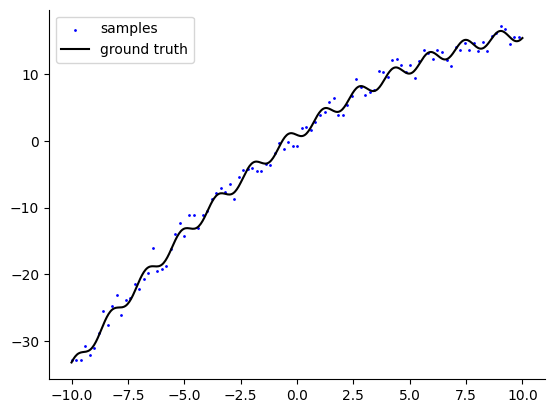

In [3]:
def get_example_synthetic_experiment_runner():
    rng = np.random.default_rng(seed=180)
    def runner(xs):
        return ground_truth(xs) + rng.normal(0, 1.0, xs.shape)
    return runner

example_synthetic_experiment_runner = get_example_synthetic_experiment_runner()

plt.scatter(study_metadata.independent_variables[0].allowed_values[::5,], example_synthetic_experiment_runner(study_metadata.independent_variables[0].allowed_values[::5,]), alpha=1, s=1, c='b', label="samples")
plt.plot(study_metadata.independent_variables[0].allowed_values, ground_truth(study_metadata.independent_variables[0].allowed_values), c="black", label="ground truth")
plt.legend()

## Theorist
We use a common BMS regressor with a common parametrization as the theorist.

In [4]:
bms_theorist = BMSRegressor(epochs=800)

## Experimentalist - Random Sampler

In [5]:
n_cycles = 9
n_observations_per_cycle = 50

random_experimentalist = make_pipeline(
    [study_metadata.independent_variables[0].allowed_values, random_sampler],
    params={"random_sampler": {"n": n_observations_per_cycle}}
)

In [6]:
%%capture
# %%capture will supress printing of warnings from BMS.
logging.disable('CRITICAL')  # Removes BMS run progress INFO print-outs.

random_experimentalist_cycle = Cycle(
    metadata=study_metadata,
    theorist=bms_theorist,
    experimentalist=random_experimentalist,
    experiment_runner=example_synthetic_experiment_runner
)

random_experimentalist_cycle.run(n_cycles);

## Evaluating Results

#### Scoring the models of each cycle
We will test the performance of the models against the ground truth. Here we generate the ground truth values across the value range as the test set.

In [7]:
X_test = study_metadata.independent_variables[0].allowed_values.reshape(-1,1)
y_test = ground_truth(X_test)

[0.9849672341041918, 0.9954121647820517, 0.9942391244693994, 0.9940459655861758, 0.995837342188189, 0.9957798769071784, 0.9961422528851704, 0.9964941170356537, 0.9945528613323756]


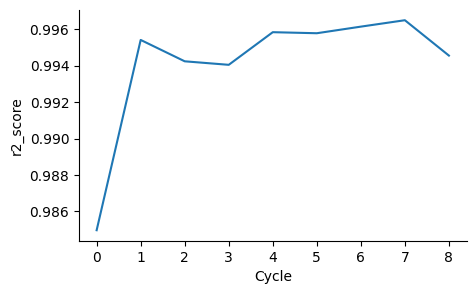

In [8]:
# Calculate the r2 scores and plot them
scores = cycle_specified_score(r2_score, random_experimentalist_cycle, X_test, y_test)
print(scores)
plot_cycle_score(random_experimentalist_cycle, X_test, y_test,
                 scorer=r2_score,
                 figsize=(5,3));

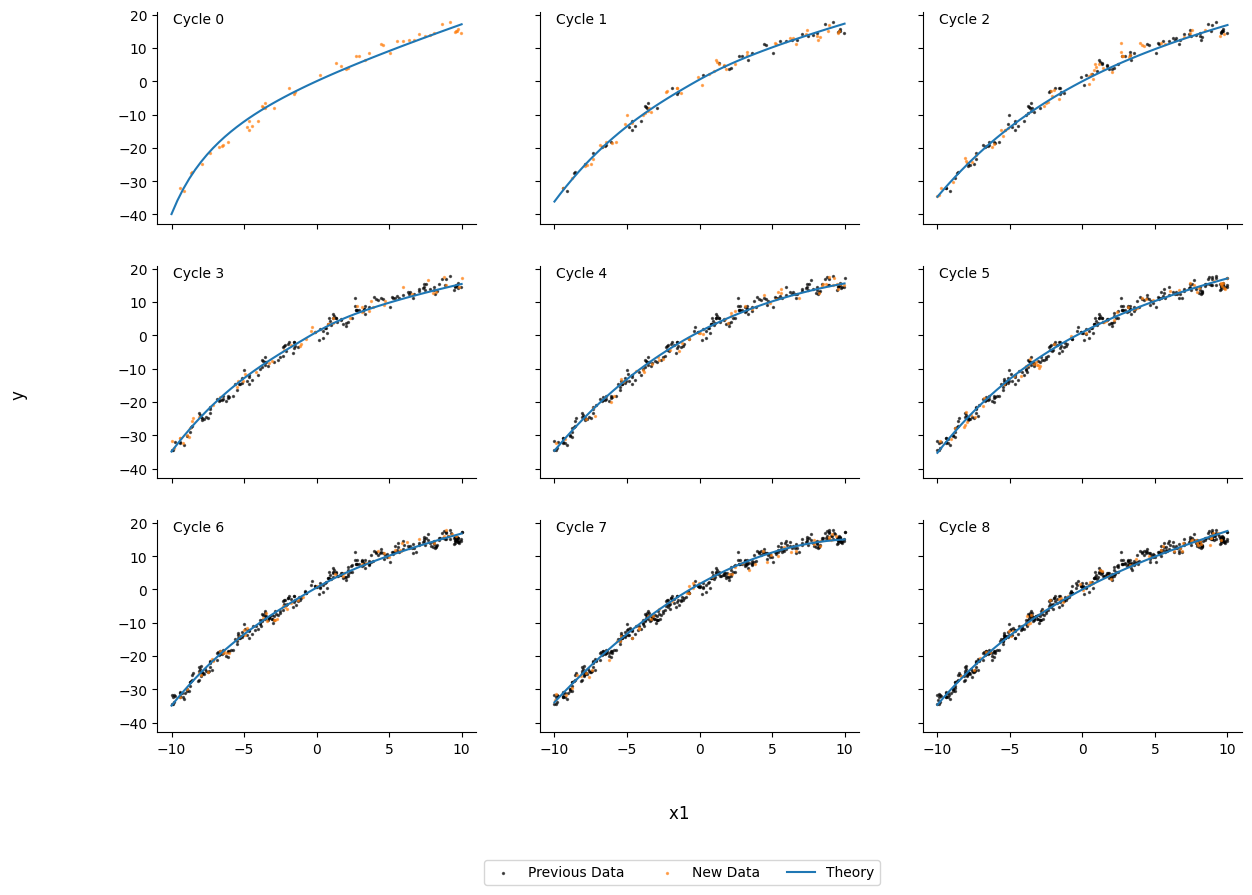

In [9]:
# Visualize the data collected and theory determined during each cycle
plot_results_panel_2d(random_experimentalist_cycle,
                      wrap=3,
                      subplot_kw=dict(figsize=(14,10))
                      );
